In [30]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [31]:
path = 'Data/Variants/SIR/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
path = 'Data/SIR_Origin/*.csv'
dic_SIRs = Load_files.load_files(path, -17, -15)

data = dic_files['대구']
data

,stdDay,Susceptible,Alpha_Infected,Alpha_Recovered,Alpha_Dead,Alpha_alpha,Alpha_beta,Alpha_gamma,Delta_Infected,Delta_Recovered,Delta_Dead,Delta_alpha,Delta_beta,Delta_gamma
0,2021-04-12,2380065,39.65,163.36,2.00,0.059242,0.058260,0.005296,0.32,0.00,0.00,0.564647,0.000000,0.0
1,2021-04-13,2380056,39.47,165.67,2.21,0.072737,0.079807,0.000000,0.50,0.00,0.00,0.441681,0.000000,0.0
2,2021-04-14,2380045,39.18,168.82,2.21,0.119906,0.037519,0.000000,0.72,0.00,0.00,0.501913,0.000000,0.0
3,2021-04-15,2380027,42.39,170.29,2.21,0.024628,0.084218,0.000000,1.08,0.00,0.00,0.074358,0.000000,0.0
4,2021-04-16,2380023,39.86,173.86,2.21,0.078574,0.052684,0.000000,1.16,0.00,0.00,0.207690,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2021-08-11,2376752,12.67,486.64,3.05,0.030942,0.132597,0.000000,814.69,726.09,0.84,0.045715,0.052928,0.0
122,2021-08-12,2376713,11.38,488.32,3.05,0.050350,0.163445,0.000000,808.62,769.21,0.84,0.067316,0.059039,0.0
123,2021-08-13,2376656,10.09,490.18,3.05,0.081696,0.136769,0.000000,815.03,816.95,0.84,0.096082,0.043459,0.0
124,2021-08-14,2376574,9.53,491.56,3.05,0.060128,0.072403,0.000000,857.51,852.37,0.84,0.063482,0.020653,0.0


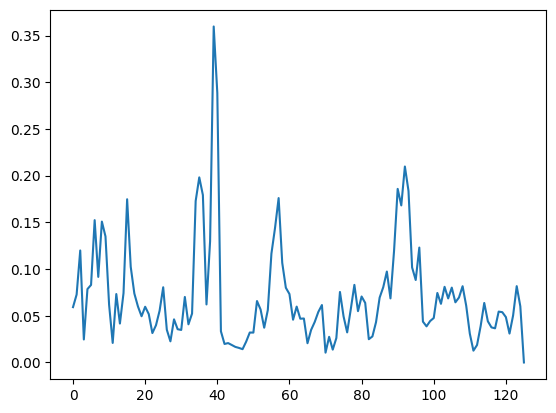

In [3]:
plt.plot(data['Alpha_alpha'])

In [4]:
path = 'hyperparameter/SIR/alpha/*.pkl'
files = glob.glob(path)
dic_hyperparameter = {}
for file in files:
    dic_hyperparameter[file[25:-4]] = load_hyperparameter(file)
    
dic_hyperparameter

{'BiGRU': [378, 0.001, 50, 8, 64, 32, 0.25],
 'BiLSTM': [431, 0.001, 50, 4, 64, 16, 0.25],
 'BiRNN': [506, 0.0001, 50, 8, 32, 16, 0.25],
 'GRU': [294, 0.001, 50, 4, 64, 32, 0.25],
 'LSTM': [613, 0.001, 50, 4, 32, 32, 0.25],
 'RNN': [434, 0.0001, 50, 8, 32, 32, 0.25],
 'seq2seq_BiGRU': [313,
  0.0001,
  20,
  4,
  64,
  8,
  0.25,
  <function utils.criterion2(actual, predict)>],
 'seq2seq_BiLSTM': [245,
  0.001,
  20,
  4,
  32,
  16,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiRNN': [714,
  0.001,
  50,
  4,
  32,
  32,
  0.25,
  <function utils.criterion2(actual, predict)>],
 'seq2seq_GRU': [242,
  0.0001,
  20,
  1,
  32,
  8,
  0.25,
  <function utils.criterion2(actual, predict)>],
 'seq2seq_LSTM': [526, 0.001, 20, 2, 32, 32, 0.25, MSELoss()],
 'seq2seq_RNN': [331,
  0.001,
  50,
  1,
  32,
  32,
  0.25,
  <function utils.criterion2(actual, predict)>]}

In [5]:
dic_model = load_model_multiple(dic_hyperparameter, 'SIR', 'alpha')

In [75]:
df = Prepare_df.processing(data, 'stdDay', 'Alpha_alpha')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

predicted_values = {}
num_model = 0
for name, state in dic_model.items():
    batch_size = dic_hyperparameter[name][4]
    if num_model < 6:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 50, 60, 1, batch_size, 'mto')
        label_y, predicted = predict_mto(state, df, x_ss, y_ms)
        
        data_predicted = data[['stdDay']].copy()

        data_predicted['Alpha_alpha'] = data['Alpha_alpha']

        data_predicted['predicted_Alpha_alpha'] = 0
        data_predicted.iloc[-1*len(predicted):, -1] = predicted

        data_predicted['Alpha_Infected'] = data['Alpha_Infected']

        data_predicted['predicted_Alpha_Infected'] = 0
        data_predicted['predicted_Alpha_Infected'] = (data['Alpha_Infected'].shift().fillna(0) 
                                                      * (1 + data['Alpha_alpha']*data['Susceptible']/dic_SIRs['대구'].iloc[0, 2] 
                                                        - data['Alpha_beta'] - data['Alpha_gamma']))

        for i in range(len(data_predicted)-13, len(data_predicted)):

            data_predicted.iloc[i, -1] = (data_predicted.iloc[i-1, -1]
                                          * (1 + data_predicted.iloc[i-1, 2]*data.iloc[i-1, 1]/dic_SIRs['대구'].iloc[0, 2]
                                            - data.iloc[i-1, 6] - data.iloc[i-1, 7]))
        
        data_predicted = data_predicted[62:].reset_index(drop = True)
        actual_Infected = data_predicted['Alpha_Infected']
        predicted_Infected = data_predicted['predicted_Alpha_Infected']
        
        predicted_values[name] = [actual_Infected, predicted_Infected]
        
    else:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 37, 60, 14, batch_size, 'mtm')
        label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 14, 0.5, device)
        
        data_predicted = data[['stdDay']].copy()

        data_predicted['Alpha_alpha'] = data['Alpha_alpha']

        data_predicted['predicted_Alpha_alpha'] = 0
        data_predicted.iloc[-1*len(all_predicted):, -1] = all_predicted

        data_predicted['Alpha_Infected'] = data['Alpha_Infected']

        data_predicted['predicted_Alpha_Infected'] = 0
        data_predicted['predicted_Alpha_Infected'] = (data['Alpha_Infected'].shift().fillna(0) 
                                                      * (1 + data['Alpha_alpha']*data['Susceptible']/dic_SIRs['대구'].iloc[0, 2] 
                                                        - data['Alpha_beta'] - data['Alpha_gamma']))

        for i in range(len(data_predicted)-13, len(data_predicted)):

            data_predicted.iloc[i, -1] = (data_predicted.iloc[i-1, -1]
                                          * (1 + data_predicted.iloc[i-1, 2]*data.iloc[i-1, 1]/dic_SIRs['대구'].iloc[0, 2]
                                            - data.iloc[i-1, 6] - data.iloc[i-1, 7]))
        
        data_predicted = data_predicted[62:].reset_index(drop = True)
        actual_Infected = data_predicted['Alpha_Infected']
        predicted_Infected = data_predicted['predicted_Alpha_Infected']
        
        predicted_values[name] = [actual_Infected, predicted_Infected]
        
    num_model += 1

RNN : 0.2683231961046106


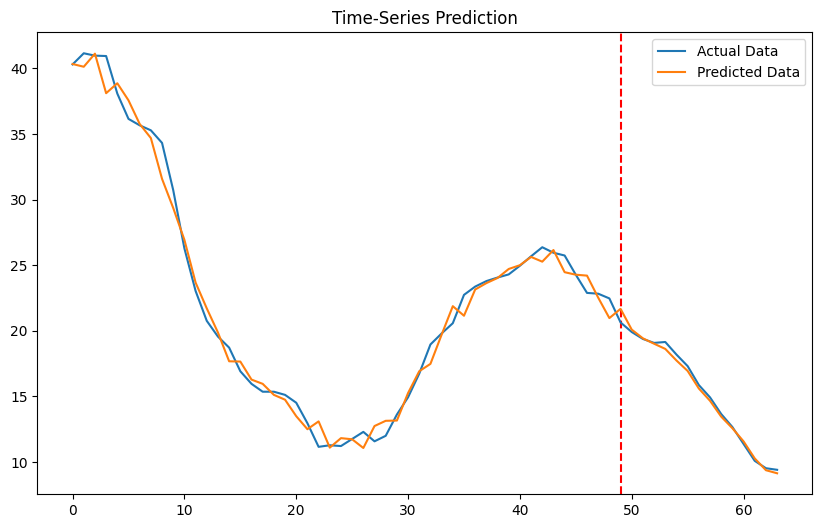

LSTM : 0.35049683863386394


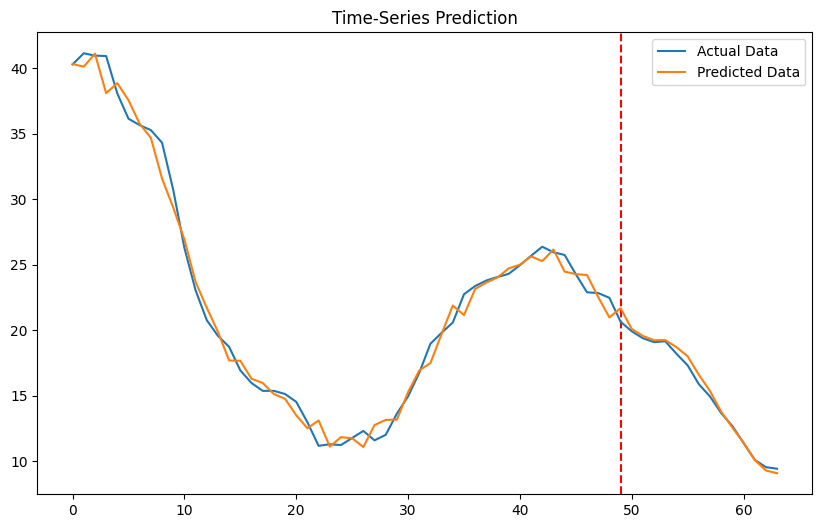

GRU : 0.21538390222107434


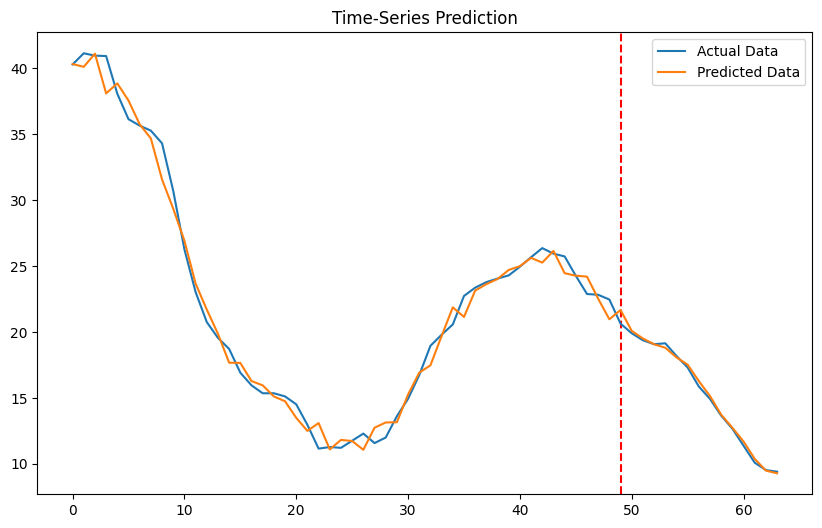

BiRNN : 0.27232404899636975


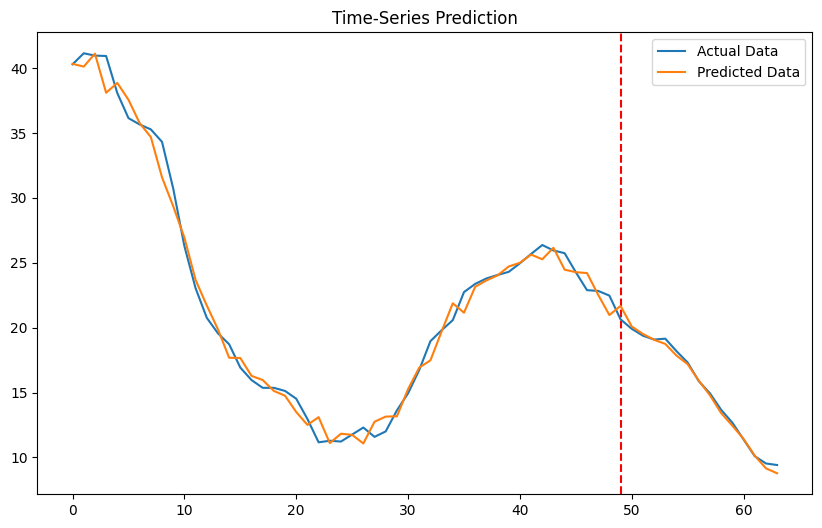

BiLSTM : 0.35784327595559


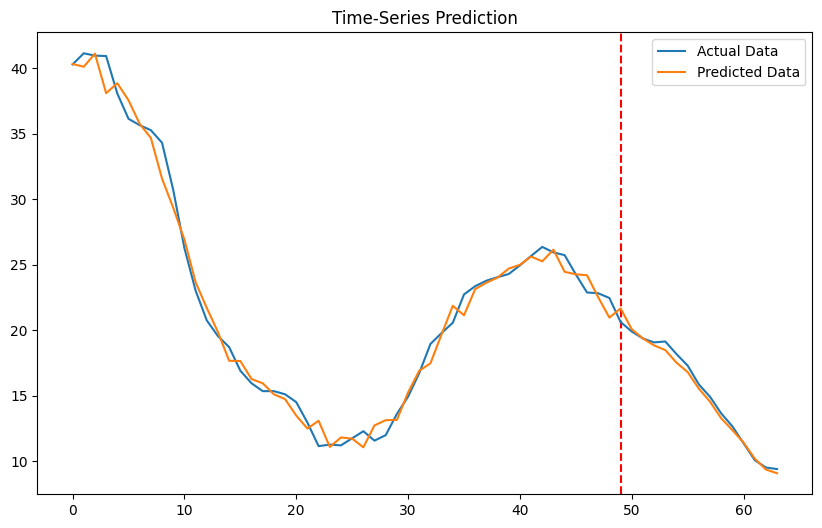

BiGRU : 0.29687490723950366


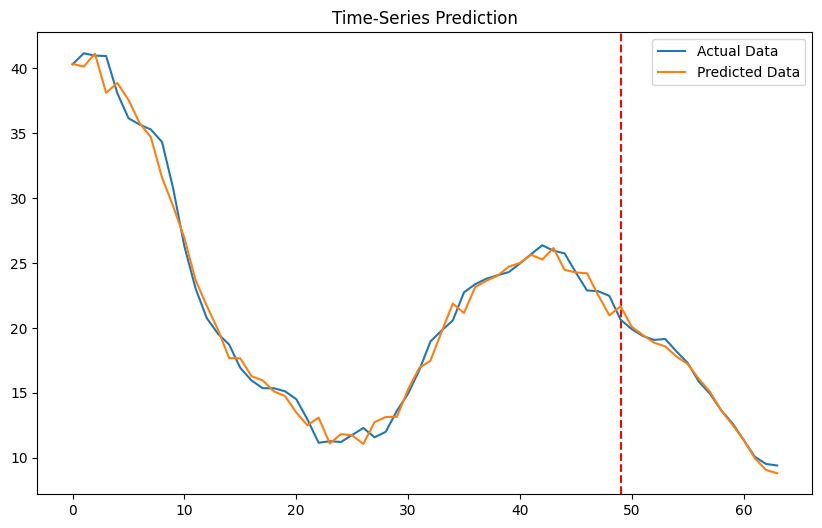

seq2seq_RNN : 0.35758018102869643


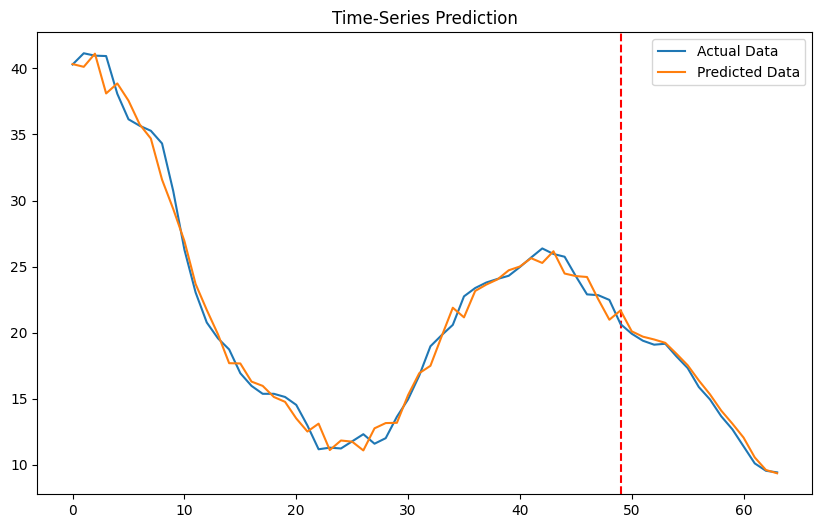

seq2seq_LSTM : 1.2223507158920228


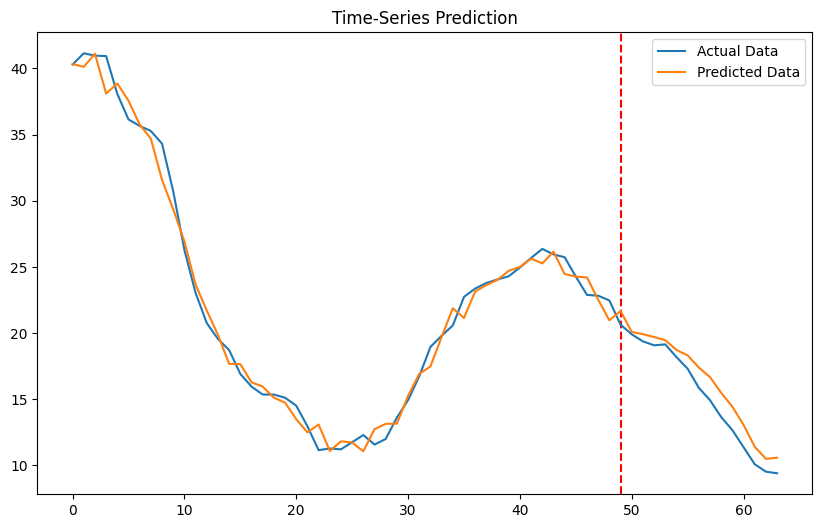

seq2seq_GRU : 1.2348701580889714


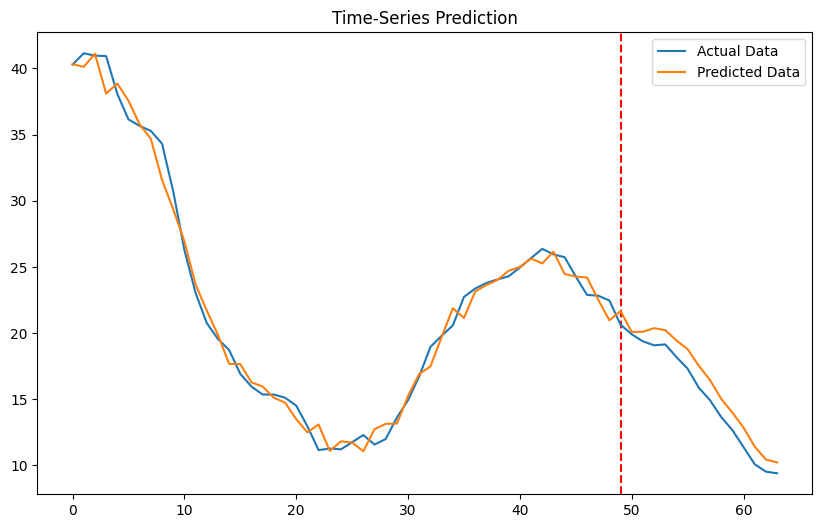

seq2seq_BiRNN : 0.48105786898145486


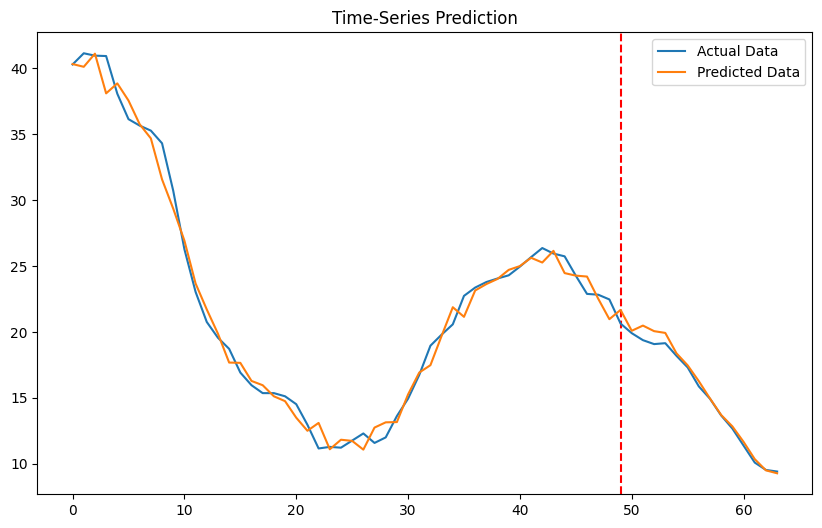

seq2seq_BiLSTM : 0.7078833255339456


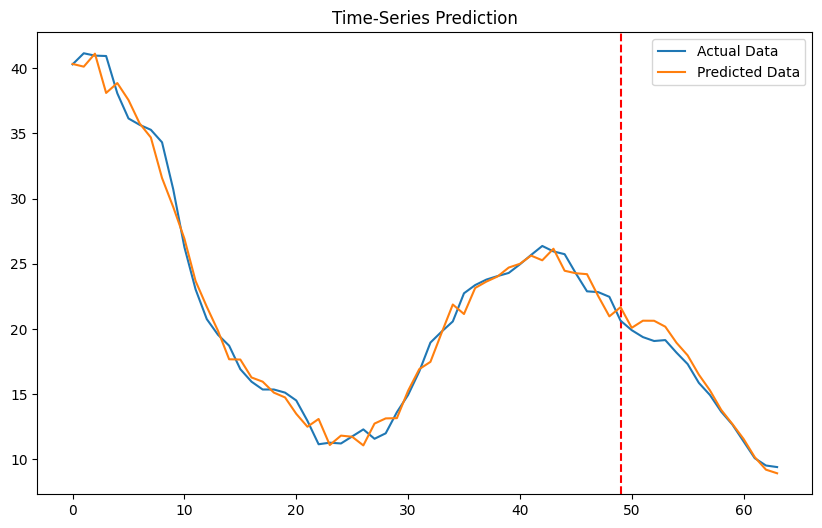

seq2seq_BiGRU : 1.6244443424979025


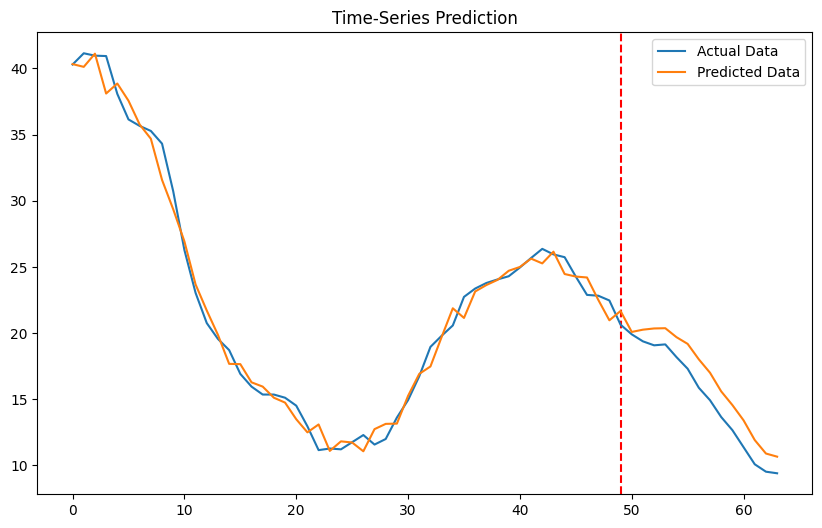

rmse가 가장 적은 모델 :  GRU


In [84]:
rmse_min = np.inf

for city, file in predicted_values.items():
    rmse_val = rmse(file[0][-14:], file[1][-14:])
    if rmse_min > rmse_val:
        rmse_min = rmse_val
        best_model = city
    print(city + ' :', rmse_val)
    plotting(file[0], file[1], 49)
    
print('rmse가 가장 적은 모델 : ', best_model)
df_predicted = pd.DataFrame()
df_predicted['Alpha_origin'] = predicted_values[best_model][0]
df_predicted['Alpha_Predicted'] = predicted_values[best_model][1]
df_predicted.index = list(data['stdDay'][-1*len(predicted_values[best_model][0]):])
df_predicted.to_csv(f'Data/Predicted/Variants/SIR/alpha_{best_model}.csv')